# Complete pipeline

## Introductory notes:
This notebook presents minimal functionality needed to go through the cleaning, ICA, spectral and event analysis stages.
* For the cleaning part, the functionality consists of resampling, filtering, bad channels and bad data spans annotation and bad channels interpolation.
* For the ICA part, it is fitting and selecting components you want to exclude.
* For the spectral analyses part, it is spectrogram+hypnogram, PSD per sleep stage and topomap per sleep stage per frequency band.
* For the events detection, it is spindles, slow waves and rapid eye movements detection and analysis.

For the extended functionality check out the corresponding notebooks.

## Import module

In [ ]:
import os
import sys
import sleepeegpy

### Run the following code

In [ ]:
import ipywidgets as widgets
from IPython.display import display

clean_bad_channels_radio = widgets.RadioButtons(
    options=['automatically', 'manually', "from-file"],
    description='Clean Bad Channels:',
    value='manually'
)
use_example_set = widgets.RadioButtons(
    options=[True, False],
    description='Use example set?',
    value=True
)
annotations_widget = widgets.RadioButtons(
    options=["automatically", "manually", "from-file"],
    description='Annotations',
    value="manually"
)
example_length_radio = widgets.RadioButtons(
    options=["short-example", "full_length"],
    description='Choose example set preference',
    value="full_length"
)

bad_channels_input = widgets.Text(
    description='Bad Channels File:',
    placeholder='Enter file name here...',
)
annotations_input = widgets.Text(
    description='Annotations File:',
    placeholder='Enter file name here...',
)

eeg_input = widgets.Text(
    description='eeg file:',
    placeholder='Enter file name here...',
)

subject_code_input = widgets.Text(
    description='subject code:',
    placeholder='Enter subject code',
)

In [ ]:
import pooch
from sleepeegpy.pipeline import (
    CleaningPipe, ICAPipe, SpectralPipe, 
    SpindlesPipe, SlowWavesPipe, RapidEyeMovementsPipe)
from sleepeegpy.dashboard import create_dashboard

## Setup Input Files

By default, all the input files are assumed to be saved in <b>input_files</b>, which will be created (if not already exists) in the notebook path. Change the following strings to use another path.
Changing the output directory is also optional.

In [ ]:
from os import makedirs

output_dir  = "output_folder" # Output path and name can be changed here
input_dir = "input_files" # input files dir can be changed here
makedirs(input_dir, exist_ok=True)
makedirs(output_dir, exist_ok=True)

### Pipeline preference:
Change the values according to how you want to use the pipeline.

In [ ]:
from IPython.display import display
display(clean_bad_channels_radio)
display(use_example_set)
display(annotations_widget)

### Add requested files
Run the code below, add all requested files (according to your preference) in the input file, and write their names.
Instructions:
- put your files in the input directory.
- Choosing eeg file: It must be a montage that works with mne.read_raw.
- For more information about the mne.read_raw supported formats, see [mne documentation](https://mne.tools/stable/generated/mne.io.Raw.html)
- If your file has no montage, but there is a channel mapping, you can add montage in the cleaning part. (there is an example below of one way to add it)

In [ ]:
display(subject_code_input)
if clean_bad_channels_radio.value == "from-file" and use_example_set.value == False:
    display(bad_channels_input)
if annotations_widget.value == "from-file" and use_example_set.value==False:
    display(annotations_input)
if use_example_set.value==False:
    display(eeg_input)
if use_example_set.value:
    display(example_length_radio)

* Modify your hypnogram file name (Point-per-row type of hypnogram) below. 
* If needed, change the Hypnogram's sampling frequency
* If you don't have a hypnogram file, follow the next notebook instructions.

In [ ]:
hypnogram_filename = "staging.txt" # If you don't have a file, replace with 'predict'
hypno_freq = 1 # If required, change Hypnogram's sampling frequency (visbrain's hypnograms default to 1)

### Modify hypnogram prediction arguments
<b>If you don't have hypnogram file</b>, choose prediction arguments.
These values will use [YASA's algorithm](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging) to create new hypnogram. 

Make sure that the electrodes you provide are clean.


In [ ]:
hypno_predict_arguments = {
    "eeg_name": "E183",
    "eog_name": "E252",
    "emg_name": "E247",
    "ref_name" : "E26",
    "save": False
}

#### Adjust variables
* Add your subject code in the following code.
* If required, change `n_components` - should be equal or less than number of channels. see [more information](https://mne.tools/stable/generated/mne.preprocessing.ICA.html)
* Modify picked channel that is part of the montage. `picked_channel` represents the EEG channel selected for plotting and computations of hypnospectrogram, PSDs, and TFRs. To have separate channels for each plot, modify the variable in the relevant notebook cells.
* Modify loc_chname and roc_chname ([Left and Right Ocular Canthi](https://raphaelvallat.com/yasa/build/html/generated/yasa.rem_detect.html)). Make sure the channel names are part of the montage.

In [ ]:
subject_code =  subject_code_input.value
n_components = 30
picked_channel = 'E101'
loc_chname = "E252"
roc_chname = "E226"

<b> You can now run the notebook (you can change values according to your needs)</b>

In [ ]:
if use_example_set.value:
    cache_dir = pooch.os_cache("sleepeegpy_dataset")
    if example_length_radio == "full-length":
        doi = "10.5281/zenodo.10362189"
    else:
        doi = "10.5281/zenodo.10362189"
    odie = pooch.create(
        path=cache_dir,
        base_url=f"doi:{doi}",
    )
    odie.load_registry_from_doi()

In [ ]:
if use_example_set.value:
    bad_channels = odie.fetch("bad_channels.txt")
    annotations = odie.fetch("annotations.txt")
    path_to_eeg = odie.fetch("resampled_raw.fif", progressbar=True)
    hypnogram_path = odie.fetch("staging.txt", progressbar=True)
    if example_length_radio.value == "full-length":
        for i in range(1,4):
        odie.fetch(f"resampled_raw-{i}.fif", progressbar=True)  
    else:
        odie.fetch(f"resampled_raw-1.fif", progressbar=True)  
     
else:
    eeg_file = eeg_input.value
    bad_channels = bad_channels_input.value
    annotations = annotations_input.value
    path_to_eeg = os.path.join(input_dir,eeg_file)
    hypnogram_path = "predict" if hypnogram_filename == "predict" else os.path.join(input_dir,hypnogram_filename)
    bad_channels = None if bad_channels == "" else os.path.join(input_dir,bad_channels) 
    annotations = None if annotations == "" else os.path.join(input_dir,annotations) 

## Cleaning

Initialize `CleaningPipe` object by providing it with path to eeg file and output directory in which you want the data to be saved.

In [ ]:
pipe = CleaningPipe(
    path_to_eeg=path_to_eeg,
    output_dir=output_dir,
)

In [ ]:
##### Adding montage example####
# import mne
# channels_map = {"E59": "C3", "E183": "C4", "E36": "F3", "E224": "F4", "E47": "F7", "E2": "F8","E37": "Fp1", "E18": "Fp2", "E21": "Fz", "E116": "O1", "E150": "O2", "E87": "P3", "E153": "P4", "E101": "Pz","E69": "T3", "E202": "T4", "E96": "T5", "E170": "T6", "E94": "A1", "E190": "A2"}
# current_channel_names = set(pipe.mne_raw.ch_names)
# channels_to_drop = list(current_channel_names - set(channels_map.keys()))
# pipe.mne_raw.drop_channels(channels_to_drop)
# mne.rename_channels(pipe.mne_raw.info, channels_map)
# montage = mne.channels.make_standard_montage('standard_1020')
# pipe.mne_raw.set_montage(montage)

### Resampling
This can take more than an hour depending on eeg signal size and specs of the computer you're running the analysis on.

In [ ]:
pipe.resample(sfreq=250)

In [ ]:
pipe.filter(l_freq=0.75, h_freq=40)

In [ ]:
pipe.notch(freqs="50s")

### Select bad channels and epochs

If you chose manually bad channels clean, select bad channels in the opened browser.

In [ ]:
if clean_bad_channels_radio.value == "manually":
    pipe.plot(save_bad_channels=True)
elif clean_bad_channels_radio.value == "automatically":
    bad_channels = pipe.auto_detect_bad_channels()

In [ ]:
pipe.read_bad_channels(path = None if clean_bad_channels_radio.value == "Manually" else bad_channels)

In [ ]:
pipe.interpolate_bads(reset_bads=True)

Select bad epochs

Click "a" -> "Add description" -> Enter BAD_EPOCH -> Annotate bad data spans

In [ ]:
if annotations_widget.value == "manually":
    pipe.plot(butterfly=True, save_annotations=True,overwrite=True)    
    pipe.read_annotations()
elif annotations_widget.value == "from-file":
    pipe.read_annotations(path = annotations)
elif annotations_widget.value == "automatically":
    pipe.auto_set_annotations()

In [ ]:
hypno_predict_arguments = hypno_predict_arguments if hypnogram_path=="predict" else None

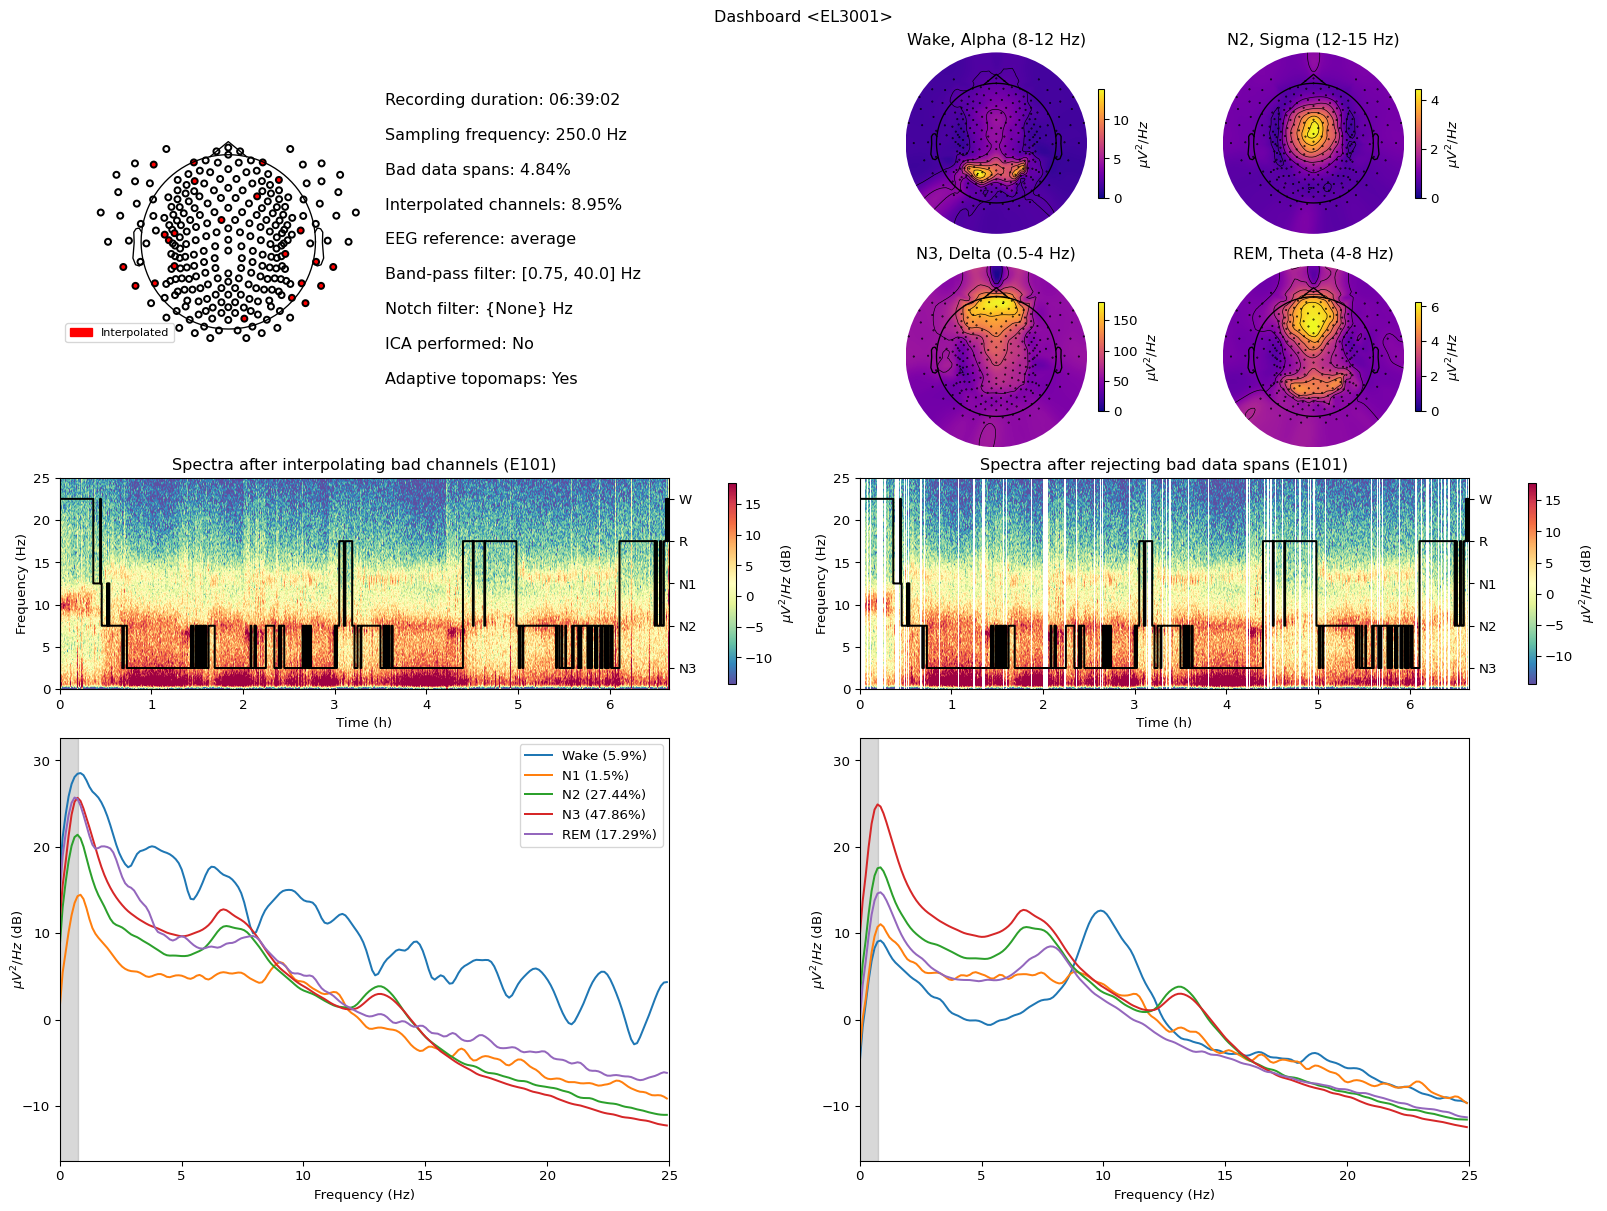

In [ ]:

fig = create_dashboard(
    subject_code=subject_code, 
    prec_pipe=pipe, 
    hypno_psd_pick=picked_channel,
    hypnogram= hypnogram_path,
    predict_hypno_args = hypno_predict_arguments,
    hypno_freq=hypno_freq,
    reference="average")

## ICA

Pass the preceding (cleaning) pipe to the ICAPipe.

In [ ]:
ica_pipe = ICAPipe(prec_pipe=pipe, n_components=n_components)

Fit the ICA on the 1 Hz high-pass filtered data.

In [ ]:
ica_pipe.fit()

Visually inspect ICA components.

In [ ]:
ica_pipe.plot_sources()

Pass to the `exclude` argument indices of components you want to remove from the raw signal.

In [ ]:
ica_pipe.apply()

## Spectral

Pass the preceding (cleaning or ICA) pipe to the SpectralPipe. Also provide pass to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

In [ ]:
spectral_pipe = SpectralPipe(
    prec_pipe=ica_pipe,
    path_to_hypno=hypnogram_path,
    hypno_freq=hypno_freq,
)

If you don't have a hypnogram, `predict_hypno` will use [YASA's algorithm](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging). 

In [ ]:
if hypnogram_path is None:
    spectral_pipe.predict_hypno(
    eeg_name = hypno_predict_arguments["eeg_name"],
    eog_name = hypno_predict_arguments["eog_name"],
    emg_name =  hypno_predict_arguments["emg_name"],
    ref_name = hypno_predict_arguments["ref_name"],
    save=False)

By default, picked_channel will be used to calculate spectrogram. You can pass another electrode name (make sure it exists)

In [ ]:
spectral_pipe.plot_hypnospectrogram(picks=[picked_channel])

In [ ]:
spectral_pipe.compute_psd(
    sleep_stages={"Wake": 0, "N1": 1, "N2/3": (2, 3), "REM": 4},
    reference="average",
    # Additional arguments passed to the Welch method:
    n_fft=1024,
    n_per_seg=1024,
    n_overlap=512,
    window="hamming",
    verbose=False
)

In [ ]:
spectral_pipe.plot_psds(picks=[picked_channel], psd_range=(-30, 30))

Create a collage with rows for sleep stages and columns for bands.

In [ ]:
spectral_pipe.plot_topomap_collage()

## Events

Pass the preceding (cleaning or ICA or spectral) pipe to one of the SpindlesPipe, SlowWavesPipe or RapidEyeMovementsPipe. If the preceding is cleaning or ICA - provide path to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

In [ ]:
spindles_pipe = SpindlesPipe(prec_pipe=spectral_pipe)

spindles_pipe.detect()
spindles_pipe.plot_average(
    center="Peak",
    hue="Stage",
    time_before=1,
    time_after=1,
)

In [ ]:
spindles_pipe.results.summary(grp_chan=False, grp_stage=True)

In [ ]:
spindles_pipe.compute_tfr(freqs=(10, 20), n_freqs=100, time_before=1, time_after=1)
spindles_pipe.tfrs["N2"].plot([picked_channel])

In [ ]:
slow_waves_pipe = SlowWavesPipe(prec_pipe=spindles_pipe)

slow_waves_pipe.detect()
slow_waves_pipe.plot_average(
    center="NegPeak",
    hue="Stage",
    time_before=0.4,
    time_after=0.8,
)

In [ ]:
slow_waves_pipe.compute_tfr(
    freqs=(0.5, 5), n_freqs=100, time_before=4, time_after=4, n_cycles=2
)
slow_waves_pipe.tfrs["N3"].plot([picked_channel])

In [ ]:
rems_pipe = RapidEyeMovementsPipe(prec_pipe=slow_waves_pipe)

rems_pipe.detect(
    loc_chname=loc_chname,
    roc_chname=roc_chname,
)

rems_pipe.plot_average(
    center="Peak",
    time_before=0.5,
    time_after=0.5,
    filt=(None, None),
    mask=None,
)